1. Dataset Choice

For this lab, we choose MNIST because:

MNIST is small enough to train quickly, even on modest hardware.

It is a common benchmark for adversarial attack research.

Security concerns around digit recognition (e.g., check processing, secure entry systems) can illustrate the impact of adversarial attacks.

Number of images used: We will use the standard MNIST dataset of 60,000 training images and 10,000 test images. From the 60,000 training images, we will create separate train, validation, and test splits.

2. Data Splits & Setup

We will demonstrate two different splitting strategies:

70/15/15 for training, validation, and testing

60/20/20 for training, validation, and testing

The PyTorch torchvision.datasets.MNIST dataset is already split into 60k training and 10k test images, so we will:

Split the 60k “training” images into train and validation based on the desired ratio.

Use the official 10k test images as our “testing” set.

Alternatively, to strictly follow the instructions, you can shuffle the entire 70k images and do your own 70/15/15 or 60/20/20.

Below is an example approach using the official 10k as a base test set, and adjusting the training split internally.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import copy
import random
from torch.utils.data import Dataset

In [ ]:
# For reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.01

# Downloading the dataset and transforming it to Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [ ]:
# Here we define a helper function to split data
def create_data_loaders(train_dataset, test_dataset, train_ratio, val_ratio):
    
    num_train = len(train_dataset) 
    indices = list(range(num_train))
    np.random.shuffle(indices)

    split_train = int(np.floor(train_ratio * num_train))
    split_val = int(np.floor((train_ratio + val_ratio) * num_train))

    train_idx = indices[:split_train]
    val_idx = indices[split_train:split_val]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader   = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
# Now we apply it for the 70/15/15 split
train_loader_70, val_loader_70, test_loader_70 = create_data_loaders(train_dataset, test_dataset,
                                                                     train_ratio=0.70,
                                                                     val_ratio=0.15)
# And the 60/20/20 split
train_loader_60, val_loader_60, test_loader_60 = create_data_loaders(train_dataset, test_dataset,
                                                                     train_ratio=0.60,
                                                                     val_ratio=0.20)

3. Baseline CNN (2 Layers)

3.1 Model Architecture <a name="model-architecture-2-layer"></a>

We will create a simple 2-layer CNN. Two convolutional layers followed by fully connected layers.

In [ ]:
class SimpleCNN_2Layer(nn.Module):
    def __init__(self):
        super(SimpleCNN_2Layer, self).__init__()
        # 1) First conv layer: from 1 channel (grayscale) to 16 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # 2) Second conv layer: from 16 channels to 32 channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Then we flatten, then fully connected
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

3.2 Training & Validation <a name="training-and-validation-2-layer"></a>

Below is a generic training loop that we can reuse. We’ll define a helper function train_and_validate(model, train_loader, val_loader, epochs, lr) to train the model and return its best version based on validation accuracy.

In [7]:
def train_and_validate(model, train_loader, val_loader, epochs=5, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    best_val_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total

        # Track best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")

    # Load best weights
    model.load_state_dict(best_model_weights)
    return model


Training on 70/15/15


In [8]:
model_2layer_70 = SimpleCNN_2Layer()
model_2layer_70 = train_and_validate(model_2layer_70, train_loader_70, val_loader_70, epochs=EPOCHS, lr=LR)


Epoch [1/5] Train Loss: 0.4708, Train Acc: 0.8518, Val Acc: 0.9613
Epoch [2/5] Train Loss: 0.0992, Train Acc: 0.9701, Val Acc: 0.9748
Epoch [3/5] Train Loss: 0.0717, Train Acc: 0.9776, Val Acc: 0.9797
Epoch [4/5] Train Loss: 0.0541, Train Acc: 0.9833, Val Acc: 0.9814
Epoch [5/5] Train Loss: 0.0420, Train Acc: 0.9871, Val Acc: 0.9821


Training on 60/20/20

In [9]:
model_2layer_60 = SimpleCNN_2Layer()
model_2layer_60 = train_and_validate(model_2layer_60, train_loader_60, val_loader_60, epochs=EPOCHS, lr=LR)

Epoch [1/5] Train Loss: 0.5076, Train Acc: 0.8343, Val Acc: 0.9606
Epoch [2/5] Train Loss: 0.0991, Train Acc: 0.9697, Val Acc: 0.9741
Epoch [3/5] Train Loss: 0.0665, Train Acc: 0.9792, Val Acc: 0.9799
Epoch [4/5] Train Loss: 0.0494, Train Acc: 0.9849, Val Acc: 0.9778
Epoch [5/5] Train Loss: 0.0399, Train Acc: 0.9873, Val Acc: 0.9840


3.3 Evaluation Metrics <a name="evaluation-metrics-2-layer"></a>

We compute accuracy, precision, recall, F1-score, and AUC-ROC. Note that AUC-ROC for multi-class can be computed in various ways (e.g., one-vs-rest). Below is a simple example using sklearn.metrics.roc_auc_score in a one-vs-rest manner:

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
            all_probs.extend(probs.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # For multi-class AUC, we use one-vs-rest approach. This requires a one-hot representation of the labels
    all_labels_one_hot = np.zeros((len(all_labels), 10))
    for i, label in enumerate(all_labels):
        all_labels_one_hot[i, label] = 1
    try:
        auc_roc = roc_auc_score(all_labels_one_hot, np.array(all_probs), multi_class="ovr")
    except ValueError:
        # In case some class doesn't appear, fallback to None
        auc_roc = None

    return acc, prec, rec, f1, auc_roc

# Evaluate the two models:
print("=== Evaluation (70/15/15) ===")
acc_70, prec_70, rec_70, f1_70, auc_70 = evaluate_model(model_2layer_70, test_loader_70)
print(f"Accuracy: {acc_70:.4f}, Precision: {prec_70:.4f}, Recall: {rec_70:.4f}, F1: {f1_70:.4f}, AUC-ROC: {auc_70}")

print("\n=== Evaluation (60/20/20) ===")
acc_60, prec_60, rec_60, f1_60, auc_60 = evaluate_model(model_2layer_60, test_loader_60)
print(f"Accuracy: {acc_60:.4f}, Precision: {prec_60:.4f}, Recall: {rec_60:.4f}, F1: {f1_60:.4f}, AUC-ROC: {auc_60}")


=== Evaluation (70/15/15) ===
Accuracy: 0.9847, Precision: 0.9849, Recall: 0.9846, F1: 0.9847, AUC-ROC: 0.9998677335643282

=== Evaluation (60/20/20) ===
Accuracy: 0.9859, Precision: 0.9859, Recall: 0.9859, F1: 0.9859, AUC-ROC: 0.9998869225365923


3.4 Comparison Table <a name="comparison-table"></a>

2-layer CNN (70/15/15):

    Accuracy: 0.9847

    Precision: 0.9849

    Recall: 0.9846

    F1: 0.9847

    AUC-ROC: 0.9998677335643282

2-layer CNN (60/20/20):

    Accuracy: 0.9859

    Precision: 0.9859

    Recall: 0.9859

    F1: 0.9859

    AUC-ROC: 0.9998869225365923


4. Bonus: 3-Layer CNN

We extend the CNN to 3 convolutional layers. For instance:

In [11]:
class SimpleCNN_3Layer(nn.Module):
    def __init__(self):
        super(SimpleCNN_3Layer, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64*3*3, 128)  # because after 3 conv+pool, size is 3x3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # -> (16, 14, 14)
        x = self.pool(self.relu(self.conv2(x))) # -> (32, 7, 7)
        x = self.pool(self.relu(self.conv3(x))) # -> (64, 3, 3)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
model_3layer_70 = SimpleCNN_3Layer()
model_3layer_70 = train_and_validate(model_3layer_70, train_loader_70, val_loader_70, epochs=EPOCHS, lr=LR)

acc_3_70, prec_3_70, rec_3_70, f1_3_70, auc_3_70 = evaluate_model(model_3layer_70, test_loader_70)
print(f"3-Layer CNN (70/15/15) => Accuracy: {acc_3_70:.4f}, Precision: {prec_3_70:.4f}, Recall: {rec_3_70:.4f}, F1: {f1_3_70:.4f}, AUC-ROC: {auc_3_70}")


Epoch [1/5] Train Loss: 0.7494, Train Acc: 0.7506, Val Acc: 0.9558
Epoch [2/5] Train Loss: 0.0944, Train Acc: 0.9700, Val Acc: 0.9731
Epoch [3/5] Train Loss: 0.0635, Train Acc: 0.9796, Val Acc: 0.9661
Epoch [4/5] Train Loss: 0.0529, Train Acc: 0.9833, Val Acc: 0.9818
Epoch [5/5] Train Loss: 0.0380, Train Acc: 0.9885, Val Acc: 0.9832
3-Layer CNN (70/15/15) => Accuracy: 0.9865, Precision: 0.9866, Recall: 0.9865, F1: 0.9865, AUC-ROC: 0.9998499740958596


5. Evasion Attacks (FGSM & PGD)

We now generate adversarial examples to fool our trained model.

5.1 Fast Gradient Sign Method (FGSM)

In [13]:
def fgsm_attack(model, images, labels, epsilon=0.2):
    # Make images require gradient
    images.requires_grad = True

    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Collect sign of gradient
    sign_data_grad = images.grad.data.sign()

    # Create adversarial image
    adv_images = images + epsilon * sign_data_grad
    # Clip to [0,1] for valid image
    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images


Generate adversarial examples on the test set and measure accuracy:

In [14]:
def test_fgsm(model, device, data_loader, epsilon):
    correct = 0
    adv_examples = []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = fgsm_attack(model, images, labels, epsilon=epsilon)
        outputs = model(adv_images)
        _, final_preds = torch.max(outputs, 1)
        correct += (final_preds == labels).sum().item()

        # Save some examples for visualization
        adv_examples.append((images[0].cpu(), adv_images[0].cpu(), labels[0].cpu(), final_preds[0].cpu()))

    final_acc = correct / len(data_loader.dataset)
    return final_acc, adv_examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2layer_70.to(device)

epsilon = 0.2
acc_fgsm, examples_fgsm = test_fgsm(model_2layer_70, device, test_loader_70, epsilon)
print(f"FGSM Attack with epsilon={epsilon}, Test Accuracy = {acc_fgsm:.4f}")

FGSM Attack with epsilon=0.2, Test Accuracy = 0.4660


5.2 Projected Gradient Descent (PGD)

PGD is an iterative version of FGSM. At each iteration, we do a small FGSM step and project back into the ϵ-ball.

In [15]:
def pgd_attack(model, images, labels, epsilon=0.2, alpha=0.01, iters=10):
    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            adv_images = images + alpha * images.grad.sign()
            # Projection: keep within epsilon-ball of original
            eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
            images = torch.clamp(ori_images + eta, 0, 1).detach_()

    return images

def test_pgd(model, device, data_loader, epsilon, alpha=0.01, iters=10):
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = pgd_attack(model, images, labels, epsilon=epsilon, alpha=alpha, iters=iters)
        outputs = model(adv_images)
        _, final_preds = torch.max(outputs, 1)
        correct += (final_preds == labels).sum().item()
    final_acc = correct / len(data_loader.dataset)
    return final_acc

acc_pgd = test_pgd(model_2layer_70, device, test_loader_70, epsilon=0.2, alpha=0.01, iters=10)
print(f"PGD Attack, Test Accuracy = {acc_pgd:.4f}")


PGD Attack, Test Accuracy = 0.7800


5.3 Visualizing Adversarial Examples & Accuracy Drop

How the images look before/after attack:

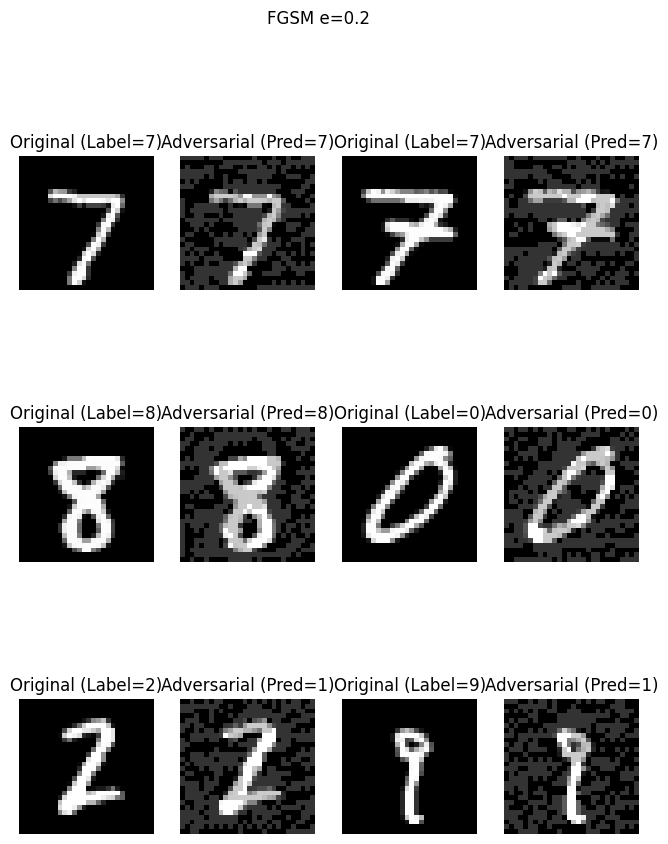

In [16]:
def visualize_adv_examples(examples, title="FGSM Examples"):
    plt.figure(figsize=(8,10))
    for i in range(6):
        original, adv, label, pred = examples[i]

        # Detach and move to CPU just in case
        original_np = original.squeeze().detach().cpu().numpy()
        adv_np = adv.squeeze().detach().cpu().numpy()

        plt.subplot(3,4,2*i+1)
        plt.title(f"Original (Label={label})")
        plt.imshow(original_np, cmap="gray")
        plt.axis('off')

        plt.subplot(3,4,2*i+2)
        plt.title(f"Adversarial (Pred={pred})")
        plt.imshow(adv_np, cmap="gray")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

visualize_adv_examples(examples_fgsm, title=f"FGSM e={epsilon}")

We observe  the drop in accuracy from the clean model (e.g., ~98-99%) to the attacked model. Also, we can experiment with varying ϵ to see the trade-off between attack strength, which gives us lower accuracy and detectability, which means there will be bigger visual perturbations.



6. Data Poisoning Attacks

Data poisoning modifies the training data to degrade or manipulate model behavior. An example is label flipping: choose a fraction of the training samples and flip their labels.

In [17]:
class PoisonedDataset(Dataset):
    def __init__(self, original_dataset, poison_ratio=0.1, flip_from=0, flip_to=1):
        self.original_dataset = original_dataset

        # Randomly select a set of indices to poison
        num_samples = len(self.original_dataset)
        num_poison = int(num_samples * poison_ratio)
        self.poison_indices = set(np.random.choice(num_samples, num_poison, replace=False))

        self.flip_from = flip_from
        self.flip_to = flip_to

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]

        # If this index is chosen for poisoning and the label matches flip_from, flip it
        if idx in self.poison_indices and label == self.flip_from:
            label = self.flip_to

        return img, label


In [ ]:
train_dataset_poisoned = PoisonedDataset(
    original_dataset=train_dataset,
    poison_ratio=0.3,     # 20% are poisoned
    flip_from=0,
    flip_to=1
)

In [ ]:
train_loader_poisoned_70, val_loader_poisoned_70, test_loader_poisoned_70 = create_data_loaders(
    train_dataset_poisoned,
    test_dataset,
    0.70,
    0.15
)

In [20]:
model_poisoned = SimpleCNN_2Layer()
model_poisoned = train_and_validate(model_poisoned, train_loader_poisoned_70, val_loader_poisoned_70,
                                    epochs=EPOCHS, lr=LR)

acc_poisoned, prec_poisoned, rec_poisoned, f1_poisoned, auc_poisoned = evaluate_model(model_poisoned, test_loader_poisoned_70)
print(f"Poisoned Model => Accuracy: {acc_poisoned:.4f}, Precision: {prec_poisoned:.4f}, Recall: {rec_poisoned:.4f}, F1: {f1_poisoned:.4f}, AUC-ROC: {auc_poisoned}")


Epoch [1/5] Train Loss: 0.5719, Train Acc: 0.8120, Val Acc: 0.9367
Epoch [2/5] Train Loss: 0.1451, Train Acc: 0.9521, Val Acc: 0.9574
Epoch [3/5] Train Loss: 0.1120, Train Acc: 0.9615, Val Acc: 0.9623
Epoch [4/5] Train Loss: 0.0970, Train Acc: 0.9660, Val Acc: 0.9601
Epoch [5/5] Train Loss: 0.0882, Train Acc: 0.9685, Val Acc: 0.9654
Poisoned Model => Accuracy: 0.9862, Precision: 0.9865, Recall: 0.9861, F1: 0.9862, AUC-ROC: 0.9999118291637521


We observe how the poisoning may degrade overall accuracy.

7. Defenses Against Adversarial Attacks

7.1 Adversarial Training

One approach is to retrain the model using a mixture of clean and adversarial examples. During each training iteration, generate adversarial examples (e.g., FGSM) on the fly and include them in the training batch. This helps the model learn robust features.

In [21]:
def adversarial_training(model, train_loader, epochs=5, lr=0.01, epsilon=0.2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            # Standard forward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Now generate adversarial examples (FGSM)
            images_adv = fgsm_attack(model, images, labels, epsilon=epsilon)
            outputs_adv = model(images_adv)
            loss_adv = criterion(outputs_adv, labels)

            # Combine losses
            total_loss = loss + loss_adv
            total_loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}")

    return model

# Example usage:
model_adv_trained = SimpleCNN_2Layer()
model_adv_trained = adversarial_training(model_adv_trained, train_loader_70, epochs=EPOCHS, lr=LR, epsilon=0.2)

# Evaluate against FGSM & PGD now
acc_fgsm_adv, _ = test_fgsm(model_adv_trained, device, train_loader_poisoned_70, epsilon=0.2)
acc_pgd_adv = test_pgd(model_adv_trained, device, train_loader_poisoned_70, epsilon=0.2, alpha=0.01, iters=10)
print(f"Adversarially Trained Model => FGSM Acc: {acc_fgsm_adv:.4f}, PGD Acc: {acc_pgd_adv:.4f}")

Epoch [1/5], Loss: 0.5944
Epoch [2/5], Loss: 0.4285
Epoch [3/5], Loss: 0.0757
Epoch [4/5], Loss: 0.2332
Epoch [5/5], Loss: 0.0600
Adversarially Trained Model => FGSM Acc: 0.6350, PGD Acc: 0.6569


The adversarially trained model is more robust to FGSM/PGD than the original.

7.2 Feature Squeezing

Feature squeezing reduces the complexity of inputs. Common approaches:

    Bit depth reduction: E.g., round pixel values to fewer bits.
    
    Median filtering or other smoothing.

In [22]:
def reduce_bit_depth(img, bits=4):
    # img in [0,1], multiply by 255, round, re-scale
    scale_factor = 2 ** bits - 1
    img = torch.round(img * scale_factor) / scale_factor
    return img

def feature_squeezing_inference(model, data_loader, bits=4):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            squeezed = reduce_bit_depth(images, bits)
            outputs = model(squeezed)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

acc_squeezed = feature_squeezing_inference(model_2layer_70, test_loader_70, bits=4)
print(f"Feature Squeezing (4-bit) Accuracy: {acc_squeezed:.4f}")

Feature Squeezing (4-bit) Accuracy: 0.9849


7.3 Differential Privacy

To protect against model inversion attacks, you can train with differential privacy, which injects noise into the gradients or parameters. A simple demonstration could be:

In [23]:
def differentially_private_training(model, train_loader, epochs=5, lr=0.01, noise_multiplier=1.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Add Gaussian noise to gradients for differential privacy
            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.randn_like(param.grad) * noise_multiplier
                    param.grad += noise

            optimizer.step()

        print(f"DP Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return model

# Example usage:
model_dp = SimpleCNN_2Layer()
model_dp = differentially_private_training(model_dp, train_loader_70, epochs=EPOCHS, lr=LR, noise_multiplier=0.1)

dp_acc, dp_prec, dp_rec, dp_f1, dp_auc = evaluate_model(model_dp, test_loader_70)
print(f"Differentially Private Model => Accuracy: {dp_acc:.4f}, Precision: {dp_prec:.4f}, "
      f"Recall: {dp_rec:.4f}, F1: {dp_f1:.4f}, AUC-ROC: {dp_auc}")

DP Epoch [1/5], Loss: 0.2212
DP Epoch [2/5], Loss: 0.1981
DP Epoch [3/5], Loss: 0.2767
DP Epoch [4/5], Loss: 0.1727
DP Epoch [5/5], Loss: 0.4716
Differentially Private Model => Accuracy: 0.9209, Precision: 0.9208, Recall: 0.9203, F1: 0.9203, AUC-ROC: 0.9951511015768333


8. Conclusion

In this lab, we:

Chose the MNIST dataset (justification: widely used, easy to train, and relevant security implications).

Implemented a 2-layer CNN baseline, evaluated on 70/15/15 and 60/20/20 splits, and compared performance metrics.

Extended to a 3-layer CNN for a bonus point.

Demonstrated evasion attacks (FGSM & PGD) and measured how accuracy drops with stronger attacks.

Explored a data poisoning attack by flipping labels in part of the training set.

Implemented and tested defense strategies: Adversarial Training, Feature Squeezing, and Differential Privacy.

Through these exercises, we observed:

How small perturbations can severely degrade model performance in evasion attacks.

How data poisoning can shift model behavior.

How defenses can help, but often at a cost (e.g., performance or training complexity).